# Bandit Problems

## Enviroment 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

## Algorithm

### 1. Thompson sampling

In [46]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

### 2. epsilon-greedy

In [47]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### 3. ucb

In [48]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### 4. Random Sampling

In [49]:
class RandomSampling:
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    @staticmethod
    def name():
        return 'random sampling'

    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

Below are some helper functions. The function simulate will simulate the learning for a single algorithm and return the mean regrets over a number of trials. The experiment function runs the simulations over all algorithms and plots their mean regrets



In [50]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets



In [51]:
def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

## Q1 Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points)

#### 1. Thompson Sampling, the parameter we can set before running is the prior distribution of each arm's reward

#### 2. e-greedy, as we can see plots below, if e-greedy agents do not explore (epsilon = 0), their regret will not decrease. If they explore too much (epsilon = 0.5), they will end up with higher regret. If they become too greedy (epsilon = 0.01), they will have longer convergence time.

#### 3. Ucb, as we can see plots below, UCB agents’ performance varied a lot with different hyperparameter confidence c. If agents are too optimistic (c =2), they will converge very slow, since they are more likely to explore other uncertain actions.

#### 4. Random-sampling, no hyperparameters. 

In [24]:
def experiment1(arm_count=10, epsilons=None, timesteps=1000, simulations=1000):
    if epsilons is None:
        epsilons = [0, 0.01, 0.1, 0.5]
    algo = EpsilonGreedy
    global epsilon
    regrets = []
    names = []
    for e in epsilons:
        epsilon = e
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(e)
    multi_plot_data(regrets, names)


def experiment2(arm_count=10, ucb_cs=None, timesteps=1000, simulations=1000):
    if ucb_cs is None:
        ucb_cs = [0, 0.1, 2]
    algo = UCB
    global ucb_c
    regrets = []
    names = []
    for c in ucb_cs:
        ucb_c = c
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(c)
    multi_plot_data(regrets, names)

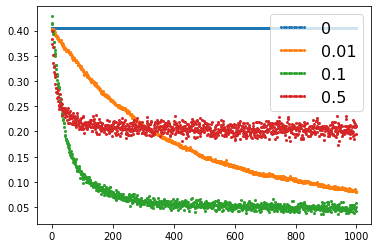

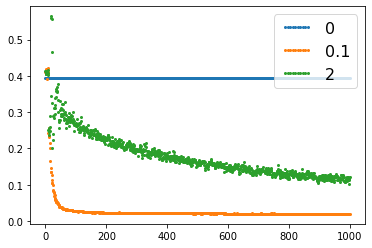

In [25]:
experiment1()
experiment2()

## Q2 How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

In [32]:
def experiment3(arm_counts=None, algos=None, timesteps=3000, simulations=1000):
    global ucb_c
    if algos is None:
        algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
    if arm_counts is None:
        arm_counts = [10, 50, 200]
    for algo in algos:
        regrets = []
        names = []
        if algo == UCB:
            for c in [2, 0.01]:
                ucb_c = c
                for arm_count in arm_counts:
                    regrets.append(simulate(simulations, timesteps, arm_count, algo))
                    names.append(arm_count)
                multi_plot_data(regrets, names)
                regrets.clear()
                names.clear()
        else:
            for arm_count in arm_counts:
                regrets.append(simulate(simulations, timesteps, arm_count, algo))
                names.append(arm_count)
            multi_plot_data(regrets, names)

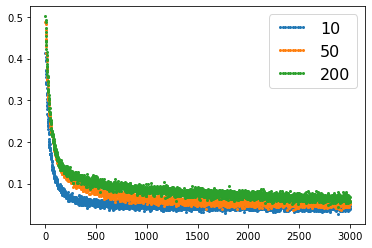

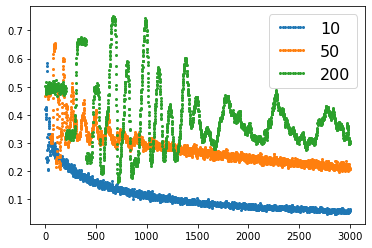

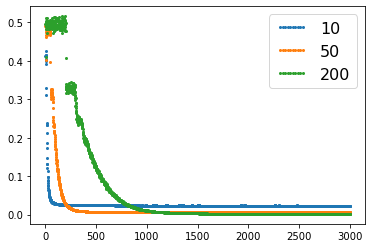

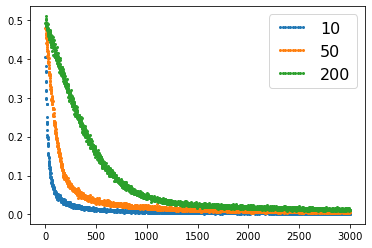

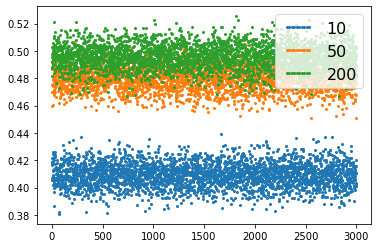

In [33]:
experiment3()

 #### 1. Thompson Sampling, we can see increasing the number of actions from 10 to 200, leaving the other parameters equal to the baseline. The Thompson agent very slowly, but surely, decreases regret to eventually outperform -greedy around step 700, another vote of confidence for Thompson. On the other hand, UCB is drastically unstable and diverges. This behaviour is not only due to the increase in action space, but due to the fact that the Bernouilli reward probabilities are so close to each other.
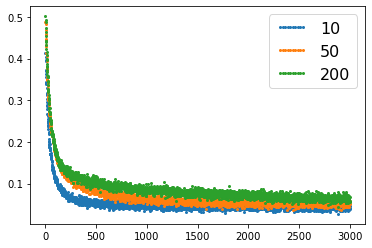

#### 2. e-greedy, when action space becomes larger (increase number of arms), the convergence time of e-greedy does not change much. Since e-greedy does not focus on exploration to get the optimal action, it can only sample from a few actions and select the best at present to keep a low regret.
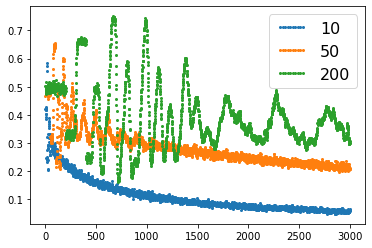

 #### 3. UCB,  As we can see plots below, UCB’s performance is unstable as the number of arms increased, and the convergence time increases as well. Just like TS, UCB’s emphasis is on exploration, so when action space getting larger it takes longer for UCB to converge. However, unlike TS, UCB has a higher probability of taking suboptimal actions consistently as action space getting larger, which makes the performance of UCB dramatically unstable. Besides, the degree that action space affects UCB also depends on the hyperparameter c. If UCB agents are less optimistic (c =0.01) rather than overly optimistic (c =2), UCB will converge shortly since there is less over-exploration and higher probability to take an optimal action. Moreover, UCB even have a better result on large action space after fine tuning.

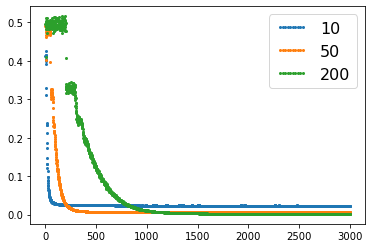
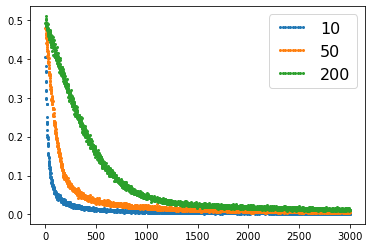

#### 4.Random Sampling, if action space increasing, the regrets increase as well. Since RS just chooses actions randomly, the more actions to select the more difficult for it to select the best one.
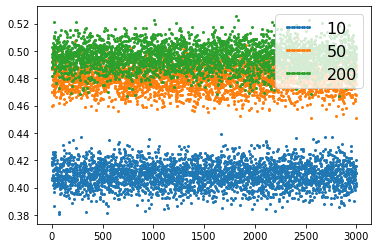

## Q3 How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

 #### 1. thompson sampling, the regret of TS will jump back to original level every 100 steps due to non-stationary environment. Since the bandit will update true reward distribution periodically, TS agents need to re-explore periodically as well. Although the regret decreases quickly, it increases over time on average. Thus, TS does not perform well in a non-stationary environment.
 
 
 #### 2. e-greedy,  it performs similarly to TS but with higher variance due to some random actions (exploration). In a non-stationary environment, the agents prefer to explore will get a better result theoretically. However, when e-greedy agents become less greedy and more likely to explore (epsilon=0.5), they do not perform better as expected.
 
 #### 3. ucb, higher emphasis on exploration will lead to a better performance in non-stationary environment. It has been confirmed by the comparison shown below. The agents with more confidence decrease their regret more quickly and improve their performance step by step (regret is decreasing over time). And agents with less confidence (or greedier agents) perform like TS and e-greedy since they prefer to exploit the best action at present rather than explore other actions.
 
 #### 4. random sampling, there is no any  influence on it, because it is random.

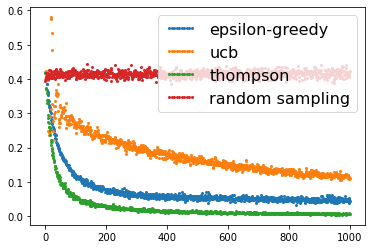

In [34]:
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

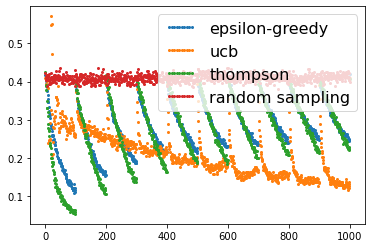

In [35]:
arm_count = 10 #number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

## Q4 When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

#### 1. Thompson Sampling, stop exploring when it gets an optimal action in a stationary environment because the more it selects the optimal action, the more reward it gets, agent will be more likely to select this action and finally it will stop

#### 2. e-greedy, epsilon=0, e-greedy agent will stop exploring once it gets the optimal action since there is no chance to do random action selections.

#### 3. UBC, UBC agent has zero confidence (c=0), it will stop exploring once it gets the optimal action since it will always select the action with highest Q-value. 

#### 4. Random Sampling, it will never stop for it select randomly

#### The exploration-exploitation trade-off is a fundamental dilemma whenever you learn about the world by trying things out. The dilemma is between choosing what you know and getting something close to what you expect (‘exploitation’) and choosing something you aren’t sure about and possibly learning more (‘exploration’).

## Q5 How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points)

#### 1. Thompson Sampling, an action with highest mean reward will be chosen. And the reward is estimated by the action’s posterior distribution and will be updated by reward the action received. Thus, the action selection will be affected by previous actions, past actions will be remembered as a form of action’s posterior distribution till the end.

#### 2. e-greedy, because it takes advantage of action-value method shown below estimating action values by the average reward of previous actions, they need to remember all the past actions

#### 3. UBC, because it takes advantage of action-value method shown below estimating action values by the average reward of previous actions, they need to remember all the past actions

#### 4. Random Sampling, Random sampling will never remember its past actions because it just simply chooses an action to do randomly，will not do any action.

## Q6 Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)
## What code is yours and what have you adapted? (10 Points)



#### Run Thompson Sampling with a normal distribution

In [55]:
class BetaAlgo():
    """
    The algos try to learn which Bandit arm is the best to maximize reward.

    It does this by modelling the distribution of the Bandit arms with a Beta,
    assuming the true probability of success of an arm is Bernouilli distributed.
    """

    def __init__(self, bandit):
        """
        Args:
          bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
        self.mu = np.ones(self.arm_count)
        self.sigma = np.ones(self.arm_count)

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        self.mu = self.alpha / (self.alpha + self.beta)
        self.sigma = 1 / (self.alpha + self.beta)

#### Change beta into random.normal(mu, sigma)

In [56]:
class BernThompson2(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson with normal distribution'

    def get_action(self):
        """ Bernouilli parameters are sampled from the normal"""
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()

#### Normal Thompson Sampling compare with the different distribution

In [57]:
def experiment5(arm_count=10, timesteps=1000, simulations=1000):
    algos = [BernThompson, BernThompson2]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)


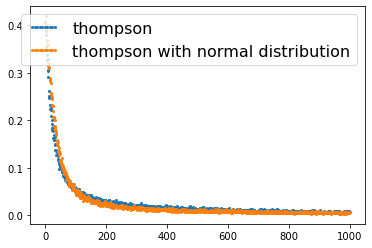

In [58]:
experiment5()

## License
#### Copyright 2022 Changning Liu

#### Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

#### The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

#### THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.